In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

# Path
import os
import random

# ML libraries
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K, callbacks
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error
import tensorflow as tf
# import tensorflow.keras as keras

In [13]:
# Dictionary consist of dataframe for each index
data = {}
data_org = {}
DATADIR = './hybrid_datasets/self_processed/new_data/CSV_File'
for filename in os.listdir(DATADIR):
    if not filename.lower().endswith(".csv"):
        continue # read only the CSV files
    filepath = os.path.join(DATADIR, filename)
    X = pd.read_csv(filepath, index_col="Date", parse_dates=True)
    X = X.fillna(0)
    # basic preprocessing: get the name, the classification
    # Save the target variable as a column in dataframe for easier dropna()
    name = X["Name"][0] # All name has the same value which is the stock company name
    del X["Name"]
    # Get df column name
    cols = X.columns
    X["Target"] = (X["Close"].pct_change().shift(-1) > 0).astype(int) # Will input 1 or 0 for up and down
    X.dropna(inplace=True)
    # Fit the standard scaler using the training dataset
#     index = X.index[X.index < TRAIN_TEST_CUTOFF] # Get index until TRAIN_TEST_CUTOFF
#     index = index[:int(len(index) * TRAIN_VALID_RATIO)] # Get train set 
#     print("index train set: ", index)
    # To set all data to standard value. Formula: ((x1-mean)/standardDeviation)
    scaler = StandardScaler().fit(X.loc[X.index, cols]) # Standardize train set
    # Save scale transformed dataframe
    X[cols] = scaler.transform(X[cols])
    # save each transformed dataframe on data dictionary
    data[name] = X

print("Data columns: ", data.keys())
print("Data Lenght: ", len(data))
print("DF Lenght: ", len(data["ENX"]))
print("Column count: ", len(data["ENX"].columns))

Data columns:  dict_keys(['ENX'])
Data Lenght:  1
DF Lenght:  1787
Column count:  22


In [3]:
data["ENX"].columns

Index(['Close', 'Volume', 'EMA10', 'EMA50', 'EMA100', 'ROC12', 'ROC24', 'AUD',
       'CAD', 'EUR', 'GBP', 'USD', 'JPY', 'JPXGY', 'NASDAQ', 'NIKKEI', 'NYSE',
       'SSE', 'GOLD', 'OIL', 'SILVER', 'Target'],
      dtype='object')

In [4]:
res_path = './hybrid_datasets/self_processed/new_data/ENX_residuals.csv'
residuals = pd.read_csv(res_path, index_col="Date", parse_dates=True)
residuals

,Residual
Date,
2015-06-09,0.000000
2015-06-10,-2.747231
2015-06-11,0.649389
2015-06-12,-1.086753
2015-06-15,-0.372565
...,...
2023-08-03,0.193007
2023-08-04,0.454664
2023-08-08,-0.989512


In [14]:
# Combine with ARIMA residuals
data["ENX"] = pd.concat([data["ENX"], residuals], axis=1)
data["ENX"]

,Close,Volume,EMA10,EMA50,EMA100,ROC12,ROC24,AUD,CAD,EUR,...,JPXGY,NASDAQ,NIKKEI,NYSE,SSE,GOLD,OIL,SILVER,Target,Residual
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-09,-1.461926,0.035923,-2.918350,-2.676020,-2.429864,0.066116,0.088039,-1.083675,-1.631497,0.073624,...,-0.714578,-1.200790,-0.706289,-1.055026,6.177354,-1.147266,0.016078,-0.790010,0,0.000000
2015-06-10,-1.463496,0.697574,-2.918350,-2.676020,-2.429864,0.066116,0.088039,-1.083675,-1.868605,0.073624,...,-0.856318,-1.181888,-0.718055,-0.987530,6.153317,-1.116420,0.086049,-0.790010,1,-2.747231
2015-06-11,-1.429482,-0.002529,-2.918350,-2.676020,-2.429864,0.066116,0.088039,-1.210436,-1.868605,0.073624,...,-0.827970,-1.180137,-0.638750,-0.976852,6.203219,-1.137669,0.050250,-0.790010,0,0.649389
2015-06-12,-1.487045,-0.275132,-2.918350,-2.676020,-2.429864,0.066116,0.088039,-1.210436,-1.868605,-0.110901,...,-0.844979,-1.189588,-0.633070,-1.010327,6.346861,-1.141782,0.006315,-0.822270,0,-1.086753
2015-06-15,-1.505361,-0.280921,-2.918350,-2.676020,-2.429864,0.066116,0.088039,-1.210436,-1.868605,-0.110901,...,-0.765605,-1.195946,-0.637614,-1.038952,6.015163,-1.119162,-0.017551,-0.760232,1,-0.372565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-03,0.547558,0.303524,0.497389,0.445200,0.521230,-1.291210,-0.810051,1.831827,0.502479,-0.664475,...,-0.130610,1.490911,2.135742,1.415224,0.294744,1.438258,1.177365,1.130679,1,0.193007
2023-08-04,0.571106,0.275397,0.511439,0.450830,0.522986,-1.163232,-0.923654,1.705066,0.739587,-0.479951,...,-0.130610,1.475722,2.143628,1.389449,0.319197,1.464305,1.246250,1.135642,0,0.454664
2023-08-08,0.518776,-0.054581,0.513567,0.454352,0.523819,-0.980385,-0.705427,1.705066,0.739587,-0.479951,...,0.062156,1.468224,2.187105,1.439372,0.231074,1.533878,1.251674,0.909824,1,-0.989512


In [6]:
# Set train test cut-off / using ENX DF as reference
TRAIN_VALID_RATIO = 0.80 # Size of training set
INDEX = int(len(data["ENX"].index) * TRAIN_VALID_RATIO) # 1340 / 0.75 * 1787
TRAIN_TEST_CUTOFF = str(data["ENX"].index[INDEX])[:10] # '2021-07-15' # limit date for training

print("Train date cut-off: ", TRAIN_TEST_CUTOFF)
print("Index cut-off: ", INDEX)

Train date cut-off:  2021-12-10
Index cut-off:  1429


In [7]:
# Data Generator
def datagen(data, seq_len, batch_size, targetcol, kind):
    """As a generator to produce samples for Keras model"""
    batch = []
    while True:
        # Pick one dataframe from the pool
        key = random.choice(list(data.keys())) # One filename from dataset
        df = data[key]
        # extract column name for features except target column and save it as an array
        input_cols = [c for c in df.columns if c != targetcol]
        # assign index for train set / Dataframe
        index = df.index[df.index < TRAIN_TEST_CUTOFF]
        # Set point of split for train and validation set / integer
        split = int(len(index) * TRAIN_VALID_RATIO)
        if kind == 'train':
            index = index[:split]   # range for the training set
        elif kind == 'valid':
            index = index[split:]   # range for the validation set
        # Pick one position, then clip a sequence length
        while True:
            t = random.choice(index)      # pick one time step / integer
            n = (df.index == t).argmax()  # find its position in the dataframe / argmax return index where the condition is true
            # Check if n length is greater than 0
            if n-seq_len+1 < 0:
                continue # can't get enough data for one sequence length
            # Get the dataframe 
            frame = df.iloc[n-seq_len+1:n+1]
            #              # ARRAY                      # 1 / integer
            batch.append([frame[input_cols].values, df.loc[t, targetcol]])
            break
        # if we get enough for a batch, dispatch
        if len(batch) == batch_size:
            # Create 1 dimensional array
            X, y = zip(*batch) # The * in a function call "unpacks" a list (or other iterable), making each of its elements a separate argument.
            # Create 4 dimensional array for X, and 1 for y
            X, y = np.expand_dims(np.array(X), 3), np.array(y)
            # returns a generator object
            yield X, y
            batch = []

In [8]:
max_list = []
for key, df in data.items():
    close_max = data[key]["Close"].describe().loc['max']
    max_list.append(close_max)
    
max_var = max(max_list)
print(max_var)

2.2216041896550127


In [9]:
# Build model
def build_model(seq_len=60, n_features=22, n_filters=(8,16,32,64,64), droprate=0.2):
    model = Sequential()
    # Input Layer
    model.add(Conv2D(n_filters[0], kernel_size=(1, n_features), activation='relu', input_shape=(seq_len, n_features, 1)))
    
    # Convolution Layer
    model.add(Conv2D(n_filters[1], kernel_size=(3, 1), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 1)))
    model.add(Conv2D(n_filters[2], kernel_size=(3, 1), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 1)))
    model.add(Conv2D(n_filters[3], kernel_size=(3, 1), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 1)))
    model.add(Conv2D(n_filters[4], kernel_size=(3, 1), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 1), name='extracted_layer'))
    
    model.add(Flatten())
    model.add(Dropout(droprate))

    # Fully Connected Layer
    model.add(Dense(1, activation='sigmoid'))
#     model.add(Dense(max_var+2, activation='relu'))
    return model

In [10]:
# Recall = (TP/(TP+FN))
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# Precision = (TP/(TP+FP))
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# F1 Score metrics
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Average of the F1 from positive and negative classification (F1-macro metric)
def f1macro(y_true, y_pred):
    f_pos = f1_m(y_true, y_pred)
    # negative version of the data and prediction
    f_neg = f1_m(1-y_true, 1-K.clip(y_pred,0,1))
    return (f_pos + f_neg)/2

In [11]:
# Optional
# Checkpoints to interupt or resume model training
checkpoint_path = "./cp2d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    callbacks.ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max", verbose=0,
                    save_best_only=True, save_weights_only=False, save_freq="epoch")
]

In [ ]:
seq_len    = 60
batch_size = 120
n_epochs   = 60
n_features = 22

# Model 
model = build_model(seq_len, n_features)
model.compile(optimizer=Adam(learning_rate=0.0001), loss="mae", metrics=["mse","accuracy", f1macro], )
History = model.fit(datagen(data, seq_len, batch_size, "Target", "train"),
          validation_data=datagen(data, seq_len, batch_size, "Target", "valid"),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=30, verbose=1)

Epoch 1/60
400/400 [==============================] - 52s 127ms/step - loss: 0.4768 - mse: 0.3096 - accuracy: 0.5365 - f1macro: 0.3898 - val_loss: 0.4876 - val_mse: 0.3174 - val_accuracy: 0.5272 - val_f1macro: 0.5024
Epoch 2/60
400/400 [==============================] - 50s 124ms/step - loss: 0.4480 - mse: 0.3893 - accuracy: 0.5584 - f1macro: 0.4925 - val_loss: 0.4605 - val_mse: 0.4464 - val_accuracy: 0.5406 - val_f1macro: 0.5124
Epoch 3/60
400/400 [==============================] - 50s 126ms/step - loss: 0.4368 - mse: 0.4183 - accuracy: 0.5668 - f1macro: 0.5171 - val_loss: 0.4705 - val_mse: 0.4659 - val_accuracy: 0.5306 - val_f1macro: 0.5009
Epoch 4/60
400/400 [==============================] - 51s 128ms/step - loss: 0.4284 - mse: 0.4138 - accuracy: 0.5764 - f1macro: 0.5250 - val_loss: 0.4772 - val_mse: 0.4691 - val_accuracy: 0.5211 - val_f1macro: 0.4939
Epoch 5/60
400/400 [==============================] - 52s 130ms/step - loss: 0.4235 - mse: 0.4111 - accuracy: 0.5824 - f1macro: 0.53

In [21]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 120, 1, 8)         184       
                                                                 
 conv2d_17 (Conv2D)          (None, 118, 1, 16)        400       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 59, 1, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 57, 1, 32)         1568      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 28, 1, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 26, 1, 32)        

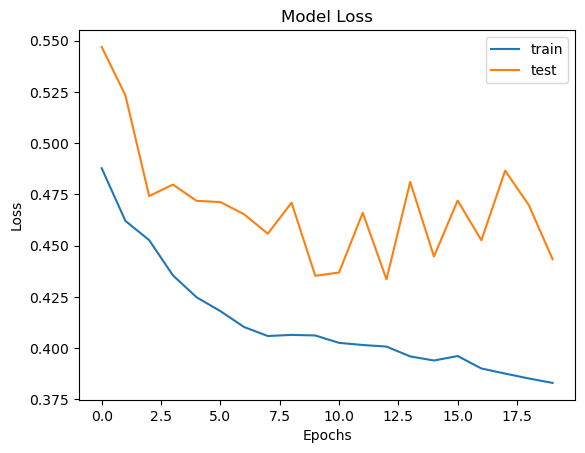

The loss value is:  0.3829745650291443
The val loss value is:  0.44334304332733154


In [22]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

print('The loss value is: ', History.history['loss'][-1])
print('The val loss value is: ', History.history['val_loss'][-1])

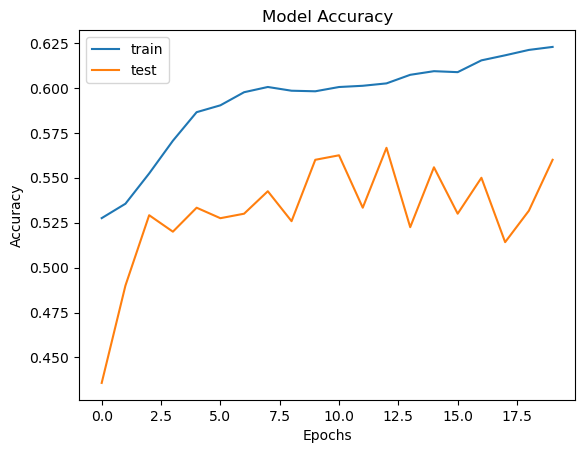

The accuracy of the model is:  62 %
The val accuracy of the model is:  56 %


In [23]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

print('The accuracy of the model is: ', int(History.history['accuracy'][-1] * 100), '%')
print('The val accuracy of the model is: ', int(History.history['val_accuracy'][-1] * 100), '%')

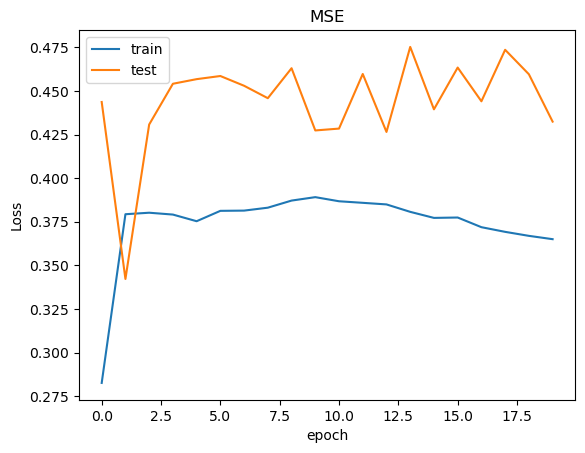

The train mse of the model is:  0.3650079667568207
The val mse of the model is:  0.4324337840080261


In [24]:
plt.plot(History.history['mse'], label='train')
plt.plot(History.history['val_mse'], label='test')
plt.title('MSE')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

print('The train mse of the model is: ', History.history['mse'][-1])
print('The val mse of the model is: ', History.history['val_mse'][-1])

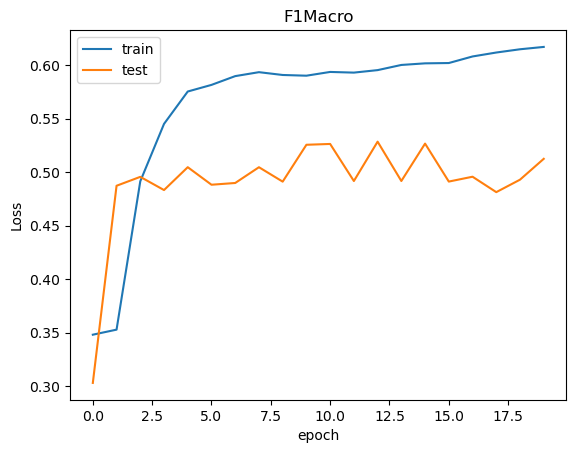

The train f1macro of the model is:  0.6171499490737915
The val f1macro of the model is:  0.5125125050544739


In [25]:
plt.plot(History.history['f1macro'], label='train')
plt.plot(History.history['val_f1macro'], label='test')
plt.title('F1Macro')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

print('The train f1macro of the model is: ', History.history['f1macro'][-1])
print('The val f1macro of the model is: ', History.history['val_f1macro'][-1])

In [13]:
plt.plot(History.history['mae'], label='train mae')
plt.plot(History.history['val_mae'], label='val mae')
plt.title('MAE')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

print('The train mae of the model is: ', int(History.history['mae'][-1] * 100), '%')
print('The val mae of the model is: ', int(History.history['val_mae'][-1] * 100), '%')

KeyError: 'mae'

In [24]:
model.save('./model_SCNNv1.h5')

C:\Users\Windows 10\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [49]:
def testgen(data, seq_len, targetcol):
    "Return array of all test samples"
    batch = []
    for key, df in data.items():
        input_cols = [c for c in df.columns if c != targetcol]
        # find the start of test sample
        t = df.index[df.index >= TRAIN_TEST_CUTOFF][0]
        n = (df.index == t).argmax()
        # extract sample using a sliding window
        for i in range(n+1, len(df)+1):
            frame = df.iloc[i-seq_len:i]
            batch.append([frame[input_cols].values, frame[targetcol][-1]])
    X, y = zip(*batch)
    return np.expand_dims(np.array(X),3), np.array(y)

# Prepare test data
test_data, test_target = testgen(data, seq_len, "Target")

# Test the model
test_out = model.predict(test_data)
# # test_pred = (test_out > 0.5).astype(int)
# print("accuracy:", accuracy_score(test_out, test_target))
# print("MAE:", mean_absolute_error(test_out, test_target))
# print("F1:", f1_score(test_out, test_target))

56/56 [==============================] - 0s 2ms/step


In [50]:
test_out.shape

(1790, 4)

In [51]:
test_out[1000]

array([0., 0., 0., 0.], dtype=float32)

In [52]:
np.unique(test_out[100],return_counts=True)

(array([0.], dtype=float32), array([4], dtype=int64))

In [28]:
test_target.shape

(1790,)

In [29]:
test_target

array([-0.01207612, -0.00345722, -0.00297361, ..., -0.00835138,
       -0.00494691,  0.00310372])

In [ ]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance and fit it to your original data
scaler = StandardScaler()
scaler.fit(data_orig["ENX"])

denormalized_forecast = scaler.inverse_transform(np.array(extracted_features_test).reshape(-1, 60))